In [1]:
# gaussian blur test

In [12]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [13]:
# load image data, remove class and reshape 
data = pd.read_pickle('images_df_numerical.pkl')['data'].to_numpy()
image_size = data[0].size
samples = data.size
image_shape = (216,334,3) # height, width , channel
# reshape every row to the image and scale to 0-1
data = [row.reshape(image_shape) for row in data]

1/1 [==============================] - 0s 97ms/step


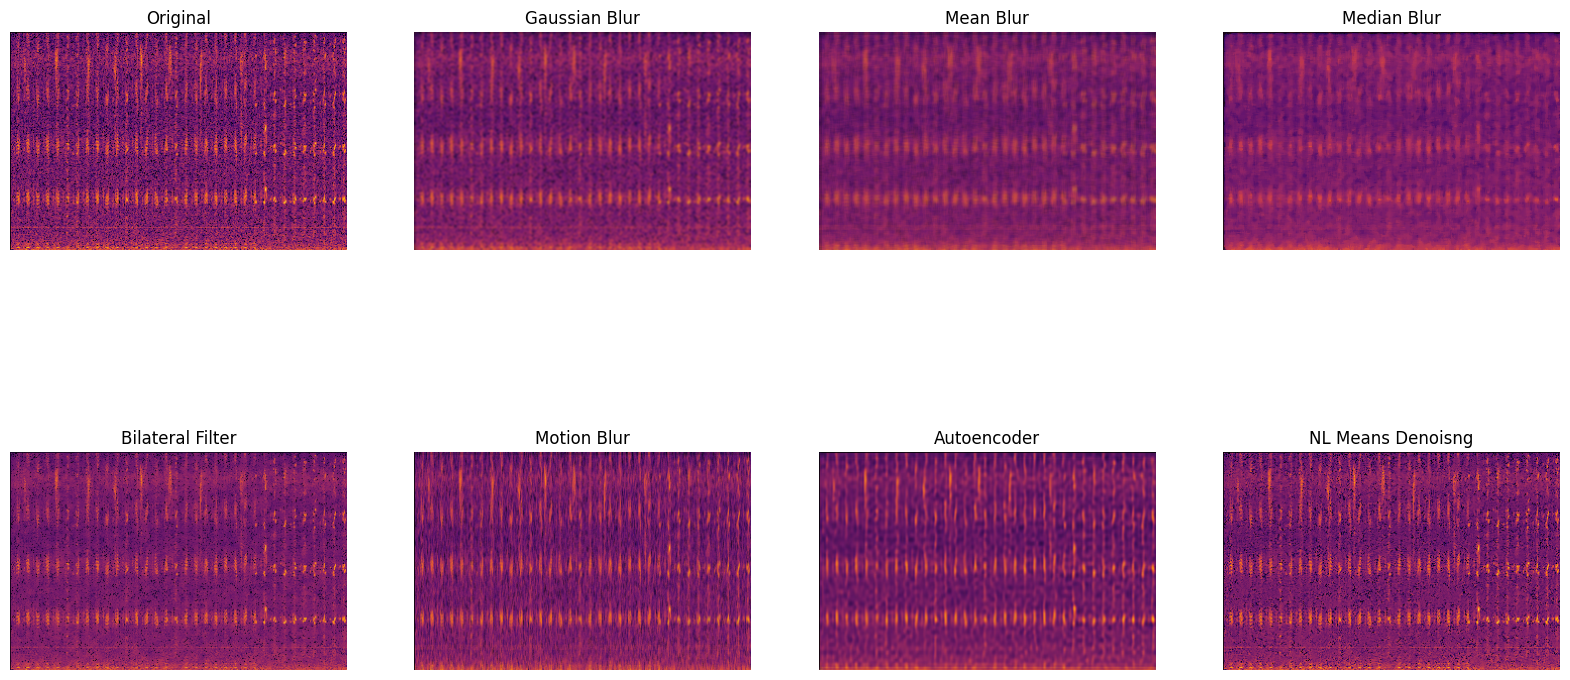

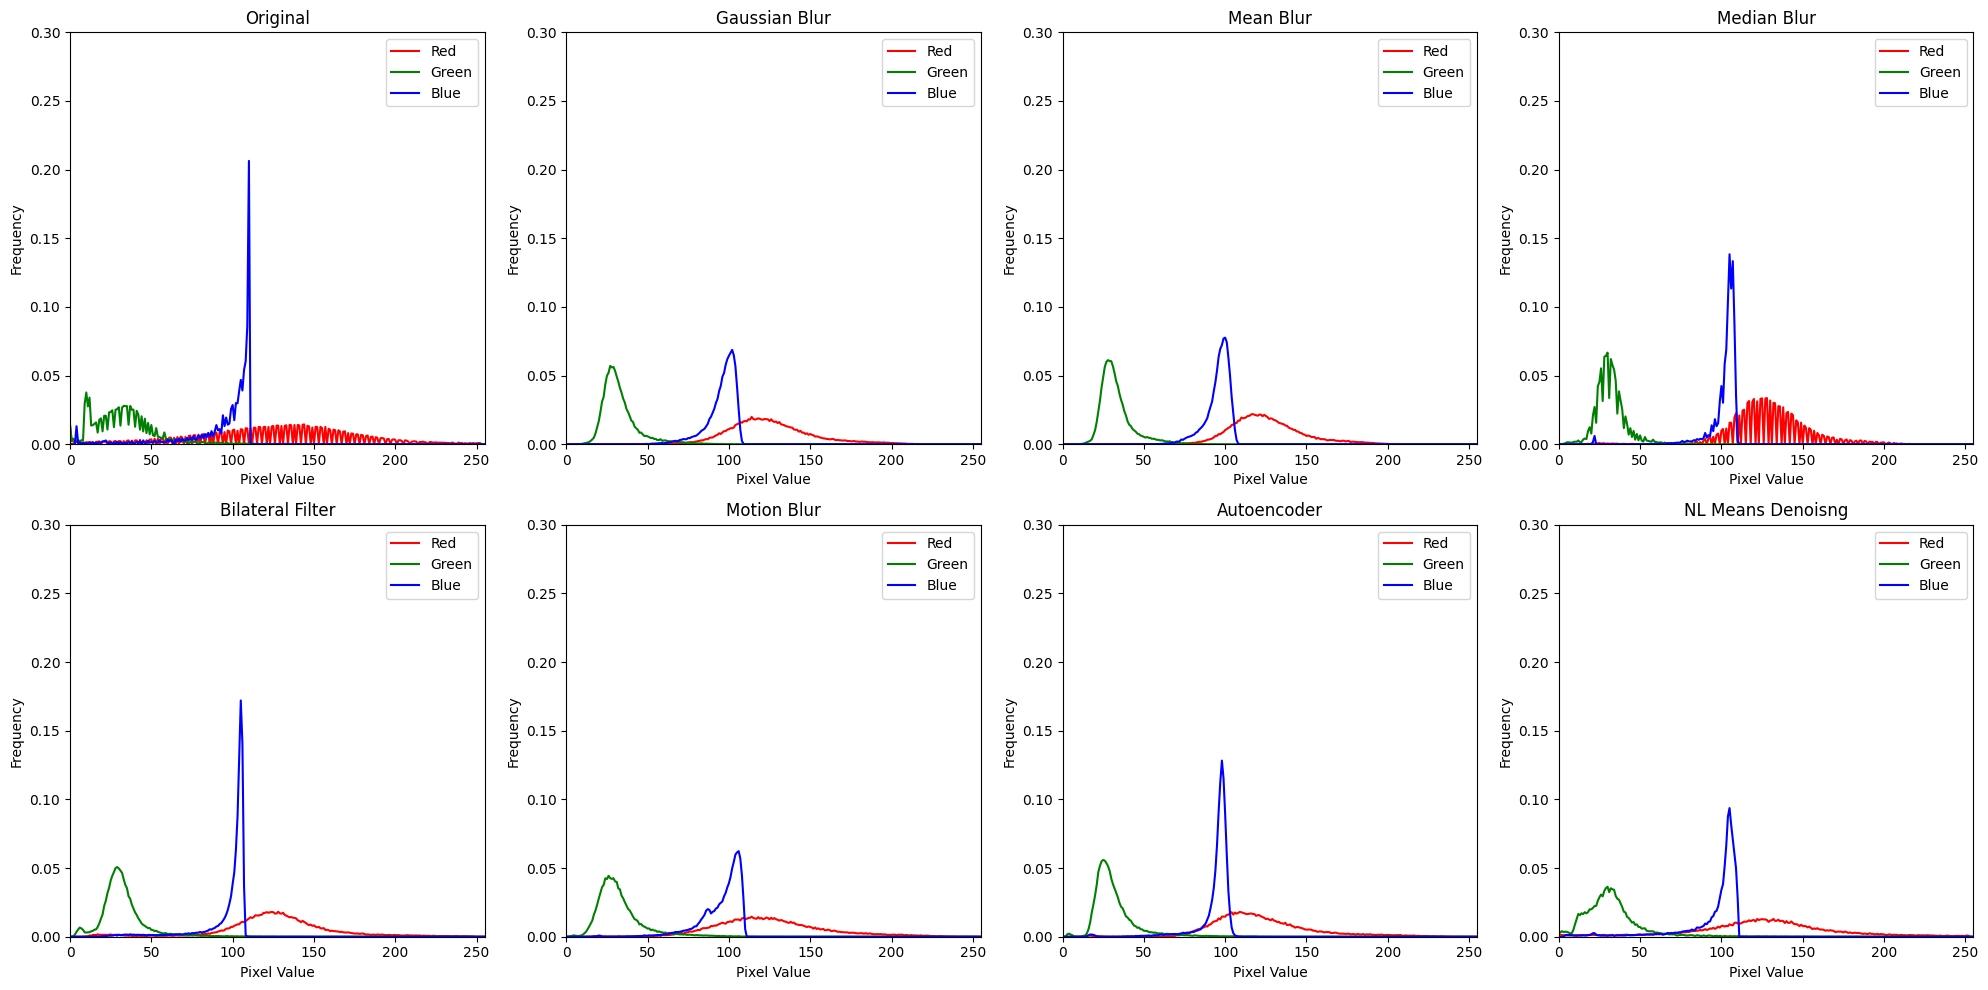

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# spektrogramme anzeigen
def show_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, 4, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    #plt.savefig("denoise_comaprison.png")
    plt.show()

# color distribution to show differences in intesities etc
def show_hist(images, titles):
    plt.figure(figsize=(20, 10))
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, 4, i)
        plt.title(title)
        #plt.axis('off')
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256]) / (image_size/3)
        hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256]) / (image_size/3)
        hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256]) / (image_size/3)

        plt.plot(hist_r, color='red', label='Red')
        plt.plot(hist_g, color='green', label='Green')
        plt.plot(hist_b, color='blue', label='Blue')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.xlim([0, 255])
        plt.ylim([0, 0.3])
    plt.tight_layout()
    #plt.savefig("denoise_comaprison_hist.png")
    plt.show()

# Laden eines Beispielbildes
image = data[0]

# Gaußscher Weichzeichner
gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)

# Mittelwertfilter
mean_blur = cv2.blur(image, (5, 5))

# Medianfilter
median_blur = cv2.medianBlur(image, 5)

# Bilateralfilter
bilateral_blur = cv2.bilateralFilter(image, 9, 75, 75)

# Bewegungsunschärfe
kernel_motion_blur = np.zeros((5, 5))
kernel_motion_blur[:, int((5-1)/2)] = 1
kernel_motion_blur /= 5
motion_blur = cv2.filter2D(image, -1, kernel_motion_blur)

# predcit based on autoencoder
autoencoder = keras.saving.load_model('./autoencoder_files/autoencoder_cnn_denoise_v6.keras')
imagelist = np.asarray([image]).astype('float32')/255.
predicted_image = (autoencoder.predict(imagelist)[0]*255.).astype('uint8')

# nl denosing
denoised_image = cv2.fastNlMeansDenoising(image, None, h=15, templateWindowSize=5, searchWindowSize=21)

# Anzeigen der Ergebnisse
show_images([image, gaussian_blur, mean_blur, median_blur, bilateral_blur, motion_blur,predicted_image,denoised_image],
            ['Original', 'Gaussian Blur', 'Mean Blur', 'Median Blur', 'Bilateral Filter', 'Motion Blur', 'Autoencoder','NL Means Denoisng'])
show_hist([image, gaussian_blur, mean_blur, median_blur, bilateral_blur, motion_blur,predicted_image,denoised_image],
            ['Original', 'Gaussian Blur', 'Mean Blur', 'Median Blur', 'Bilateral Filter', 'Motion Blur', 'Autoencoder','NL Means Denoisng'])



In [101]:
import cv2

def compare_histograms(images, titles):
    num_images = len(images)

    # Load the original image
    original_image = data[0]
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    hist_original_r = cv2.calcHist([original_image_rgb], [0], None, [256], [0, 256])
    hist_original_g = cv2.calcHist([original_image_rgb], [1], None, [256], [0, 256])
    hist_original_b = cv2.calcHist([original_image_rgb], [2], None, [256], [0, 256])

    # Initialize lists to store individual channel scores
    correlation_scores = []
    chi_square_scores = []
    intersection_scores = []
    bhattacharyya_scores = []

    for i, (image_path, title) in enumerate(zip(images[1:], titles[1:]), 1):
        # Load the current image
        current_image = image_path
        current_image_rgb = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)

        # Calculate histograms for the current image
        hist_current_r = cv2.calcHist([current_image_rgb], [0], None, [256], [0, 256])
        hist_current_g = cv2.calcHist([current_image_rgb], [1], None, [256], [0, 256])
        hist_current_b = cv2.calcHist([current_image_rgb], [2], None, [256], [0, 256])

        # Calculate histogram comparison metrics for each channel
        correlation_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_CORREL)
        chi_square_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_CHISQR)
        intersection_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_INTERSECT)
        bhattacharyya_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_BHATTACHARYYA)

        correlation_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_CORREL)
        chi_square_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_CHISQR)
        intersection_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_INTERSECT)
        bhattacharyya_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_BHATTACHARYYA)

        correlation_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_CORREL)
        chi_square_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_CHISQR)
        intersection_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_INTERSECT)
        bhattacharyya_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_BHATTACHARYYA)

        # Calculate average scores for each metric
        avg_correlation = (correlation_r + correlation_g + correlation_b) / 3
        avg_chi_square = (chi_square_r + chi_square_g + chi_square_b) / 3
        avg_intersection = (intersection_r + intersection_g + intersection_b) / 3
        avg_bhattacharyya = (bhattacharyya_r + bhattacharyya_g + bhattacharyya_b) / 3

        # Append the average scores to the lists
        correlation_scores.append(avg_correlation)
        chi_square_scores.append(avg_chi_square)
        intersection_scores.append(avg_intersection)
        bhattacharyya_scores.append(avg_bhattacharyya)

    # Print the average scores
    # in nem dataframe:
    scores = pd.DataFrame({'Image':titles[1:],'Correlation':correlation_scores,'Chi-Square':chi_square_scores,'Intersection':intersection_scores,'Bhattacharyya':bhattacharyya_scores})
    print(scores)
    #print best values
    # best values: 
    #   Correlation: 1
    #   Chi-Square: 0
    #   Intersection: +infinity
    #   Bhattacharyya: 1
    print("Best Correlation:")
compare_histograms([image, gaussian_blur, mean_blur, median_blur, bilateral_blur, motion_blur,predicted_image,denoised_image],
            ['Original', 'Gaussian Blur', 'Mean Blur', 'Median Blur', 'Bilateral Filter', 'Motion Blur', 'Autoencoder','NL Means Denoisng'])


               Image  Correlation     Chi-Square  Intersection  Bhattacharyya
0      Gaussian Blur     0.516027   65463.893399  40443.666667       0.474657
1          Mean Blur     0.489047   80459.774487  37329.333333       0.510756
2        Median Blur     0.694120   59825.780207  43446.333333       0.374915
3   Bilateral Filter     0.542146   62864.366597  42884.000000       0.432795
4        Motion Blur     0.604019   45042.868360  47807.333333       0.382661
5        Autoencoder     0.451577  115058.923208  37339.333333       0.501893
6  NL Means Denoisng     0.697782   29066.971746  53066.000000       0.296952
Best Correlation:
